In [111]:
import ingestor, modeller, fitter
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [135]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', grid=False)
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from importlib import reload

reload(ingestor)
reload(modeller)
reload(fitter)

<module 'fitter' from '/media/dwu402/Data/wrap-mad/fitter.py'>

In [4]:
context = ingestor.initialise_context()
ingestor.read_run_file(context, "runs/mouse4.3.run")

In [5]:
model = modeller.Model(context)

In [6]:
solver = fitter.Fitter()
solver.construct_objectives(context, model)

In [7]:
solver.construct_problems()

{}


In [8]:
for rhoi in np.logspace(-1, 5, num=41):
    solver.solve(rhoi)

In [9]:
solver.solutions

{'0.1': [      fun: 0.02499447795220675
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([ 4.88082719e-07,  2.62516895e-05,  6.91407537e-05,  8.36882418e-05,
         -6.22543960e-05, -7.85222881e-05,  5.62333408e-05, -1.25890287e-05,
          1.14075679e-05, -4.14884815e-05,  1.11557654e-04])
    message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
       nfev: 119
        nit: 33
     status: 0
    success: True
          x: array([ 0.        ,  0.        ,  1.7088299 ,  0.73578531,  0.49772459,
          0.0811459 ,  1.94471123, 12.55748801,  3.59210638,  1.78963456,
          0.        ])], '0.14125375446227545': [      fun: 0.0273145316386938
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([ 9.42275926e-05,  5.21942028e-04, -3.24672632e-04,  3.25016313e-04,
          1.05613853e-03, -3.83872823e-03, -4.55701038e-04, -5.34274178e-04,
         -2.92149744e-04, -7.81487912e-05,  8.60929304e-04])
    message: b'CONVE

## Validation

In [10]:
## Validation of the outer jacobian
ca = fitter.ca
dHdc = ca.hcat([ca.gradient(solver._inner_objective._obj_1, ci) 
                for ci in model.cs]).reshape((1, 3*model.K))
d2Jdc2 = ca.hcat([ca.jacobian(solver._inner_objective.inner_jacobian, ci) 
                  for ci in model.cs]).reshape((3*model.K, 3*model.K))
dJ2dcdp = ca.hcat([ca.jacobian(solver._inner_objective.inner_jacobian, pi) 
                   for pi in model.ps]).reshape((3*model.K, len(model.ps)))

In [14]:
dHdc_fn = ca.Function("dhdcfn", solver._inner_objective.input_list, [dHdc])
d2Jdc2_fn = ca.Function("d2jdc2", solver._inner_objective.input_list, [d2Jdc2])
dJ2dcdp_fn = ca.Function("d2jdcdp", solver._inner_objective.input_list, [dJ2dcdp])

In [15]:
in_arg = [model.observation_times, *fitter.argsplit(solver.problems[0].cache.recent, 3), 
          *[0.3, 1, 0.7, 1, 2, 1, 1, 1, 1, 1, 0], 
          solver._inner_objective.generate_collocation_matrix(context['datasets'][0], model), 
          len(context['datasets'][0]['t']), 
          *solver._inner_objective.pad_observations(context['datasets'][0]['y']), 1000]

In [16]:
dhdc_eval = dHdc_fn(*in_arg)
d2jdc2_eval = d2Jdc2_fn(*in_arg)
dj2dcdp_eval = dJ2dcdp_fn(*in_arg)

In [17]:
def numerical_log(matrix):
    return np.log(np.fabs(np.array(matrix))+1e-16)

Text(0.5, 1.0, 'Jacobian of the Outer Objective wrt. Spline Coefficients')

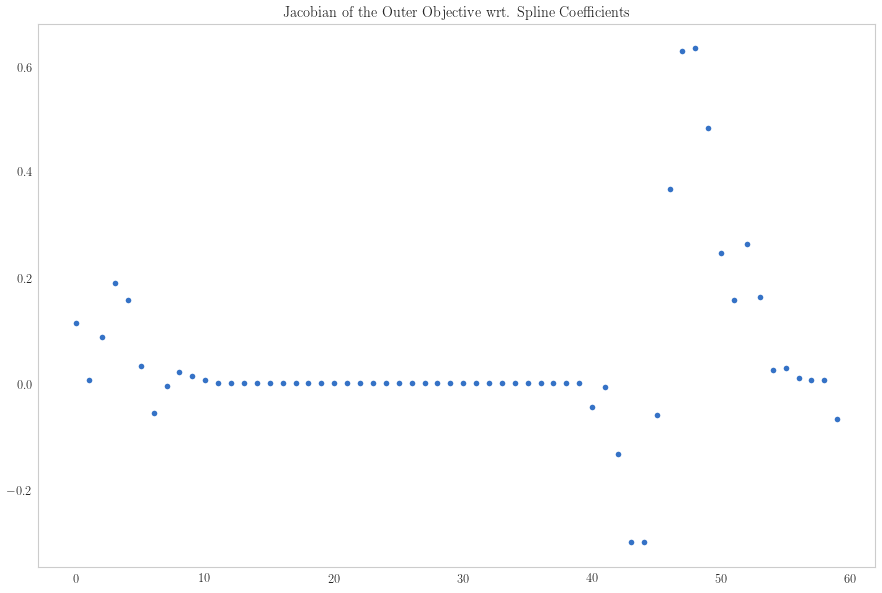

In [136]:
plt.plot(np.array(dhdc_eval).reshape(-1,), 'o')
plt.title("Jacobian of the Outer Objective wrt. Spline Coefficients")

Text(0.5, 1.0, 'Hessian of Inner Objective wrt Spline Coefficients (Log Transformed)')

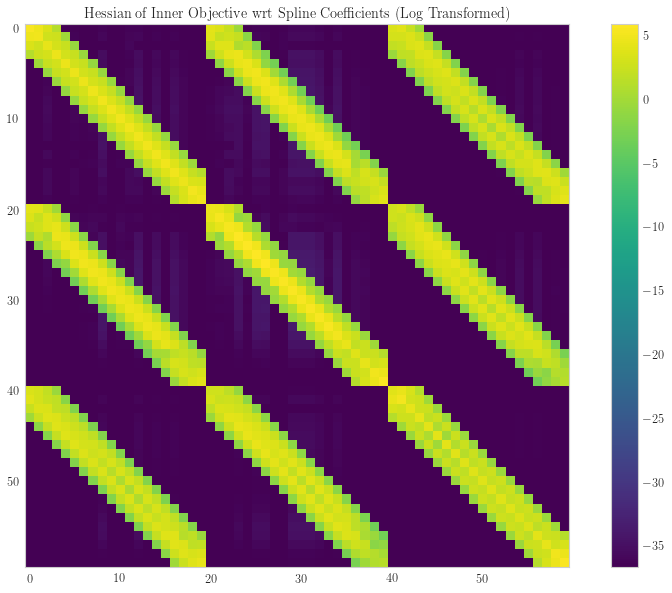

In [137]:
plt.imshow(numerical_log(d2jdc2_eval))
plt.colorbar()
plt.title("Hessian of Inner Objective wrt Spline Coefficients (Log Transformed)")

Text(0.5, 0, 'Spline Coefficicents')

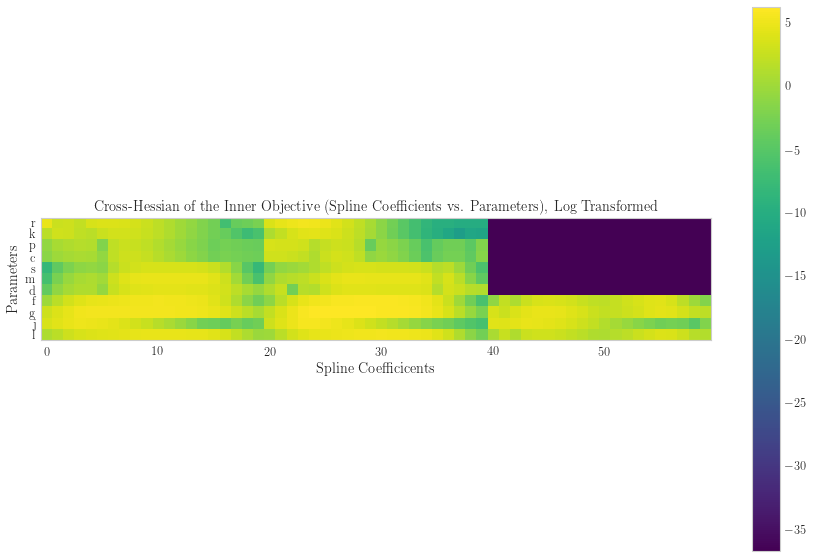

In [138]:
plt.imshow(numerical_log(dj2dcdp_eval).T)
plt.colorbar()
plt.title("Cross-Hessian of the Inner Objective (Spline Coefficients vs. Parameters),"
          " Log Transformed")
plt.yticks(range(11), "rkpcsmdfgjl")
plt.ylabel("Parameters")
plt.xlabel("Spline Coefficicents")

Text(0.5, 1.0, 'Observation Matrix')

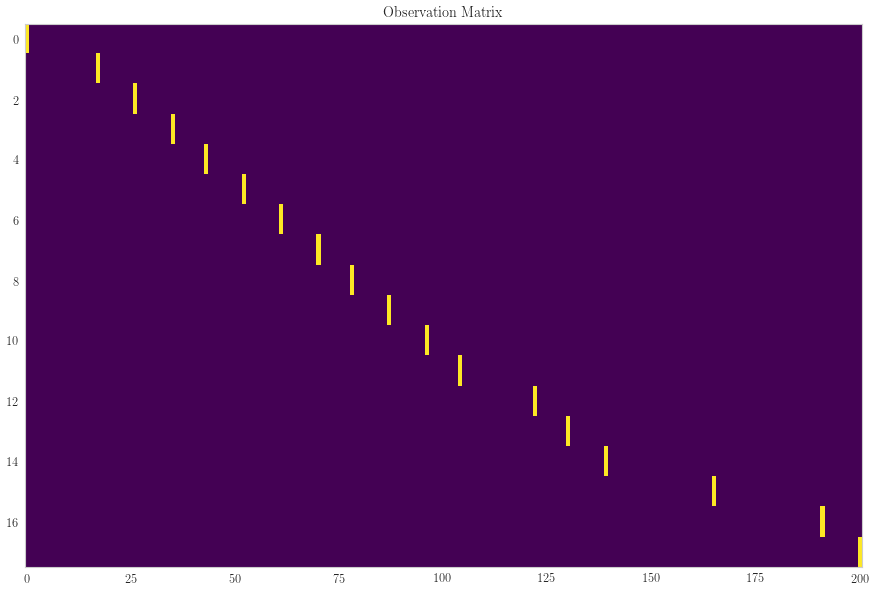

In [139]:
H_num = solver._inner_objective.generate_collocation_matrix(context['datasets'][0], model)
plt.imshow(H_num, aspect='auto')
plt.title("Observation Matrix")

In [23]:
# create and profile calls

obj_fn, obj_jac = solver._inner_objective.create_objective_functions(model, 
                                                                     context['datasets'][0])

c_test = np.array(solver.problems[0].cache.recent)

%timeit obj_fn(c_test, [0.3, 1, 0.7, 1, 2, 1, 1, 1, 1, 1 , 1e-4], rho=1000)

34 ms ± 490 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
getx = ca.Function("getx", [model.ts, *model.cs], model.xs)

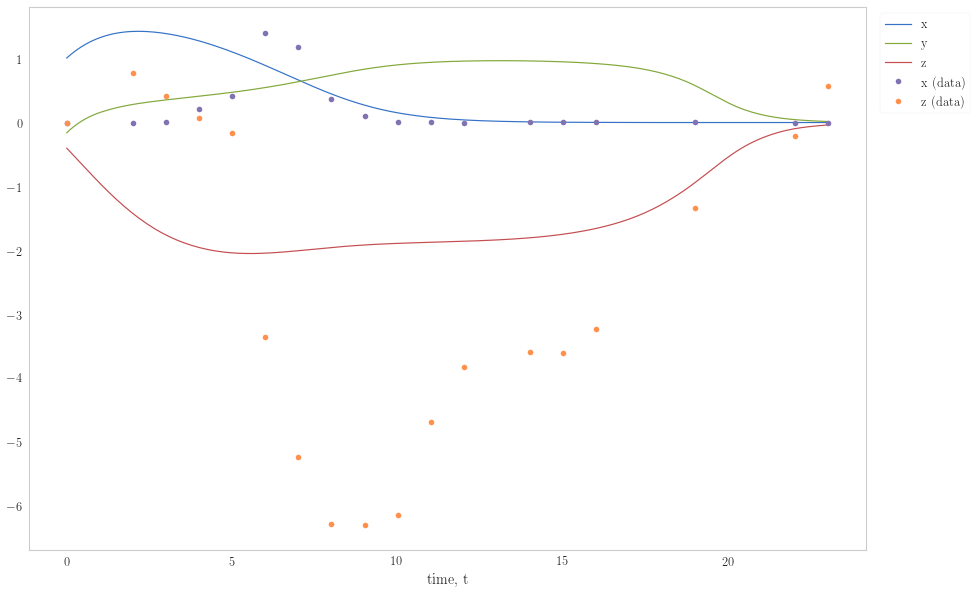

In [140]:
xs = np.array([np.array(i) for i in getx(model.observation_times, 
                                         *fitter.argsplit(solver.problems[0].cache.recent, 
                                                          3)
                                        )])
plt.plot(model.observation_times, np.hstack([xs[0], xs[1], xs[2]]),
         context['datasets'][0]['t'], context['datasets'][0]['x'], 'o',
         context['datasets'][0]['t'], context['datasets'][0]['z'], 'o')
plt.legend(list("xyz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

iv = [xs[i][0].item() for i in range(3)]

Text(0, 0.5, 'z, Health')

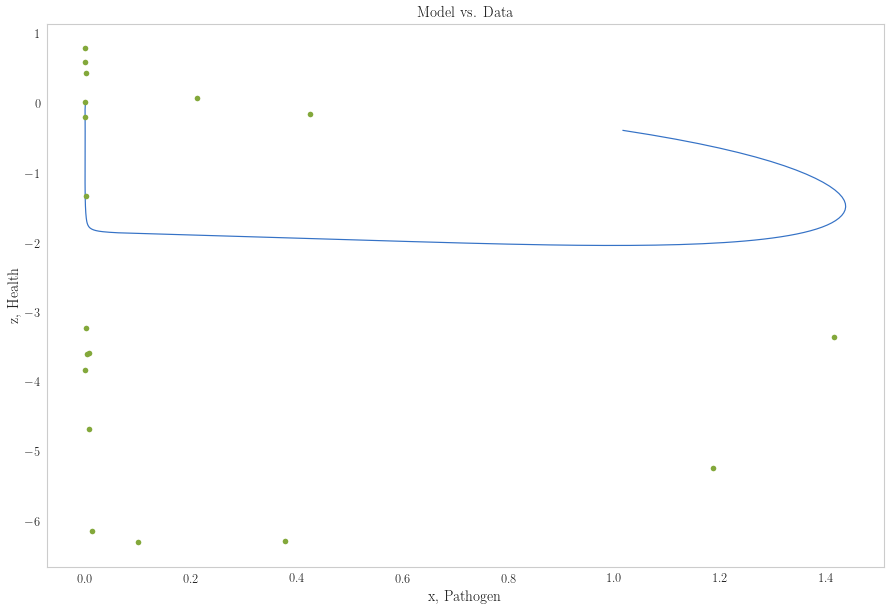

In [141]:
plt.plot(xs[0], xs[2], context['datasets'][0]['x'], context['datasets'][0]['z'], 'o')
plt.title("Model vs. Data")
plt.xlabel("x, Pathogen")
plt.ylabel("z, Health")

In [29]:
from scipy import integrate

sol = integrate.solve_ivp(lambda t, y: context['model'](t, y, [0.13045061, 0.49502786,
                                                               0.        , 7.82191343,
                                                               2.74213591, 1.72695431,
                                                               0.6231896 , 0.40515692,
                                                               0.11586408, 8.59328222,
                                                               1.29696122]),
                                                         [0, 24], iv)

sol.y[2]

array([-4.02596078e-01, -9.16734323e-01, -6.16792884e+00, -2.15826702e+01,
       -3.92660759e+01, -5.96095196e+01, -8.32163807e+01, -1.10961192e+02,
       -1.45515305e+02, -1.92026216e+02, -2.60400912e+02, -3.71934997e+02,
       -5.78688904e+02, -9.19530123e+02])

In [31]:
outer_evals = {r:v[0].fun for r, v in solver.solutions.items()}

outer_list = np.array([[float(key), value] for key, value in outer_evals.items()])

Text(0.5, 1.0, "'L'-Curve")

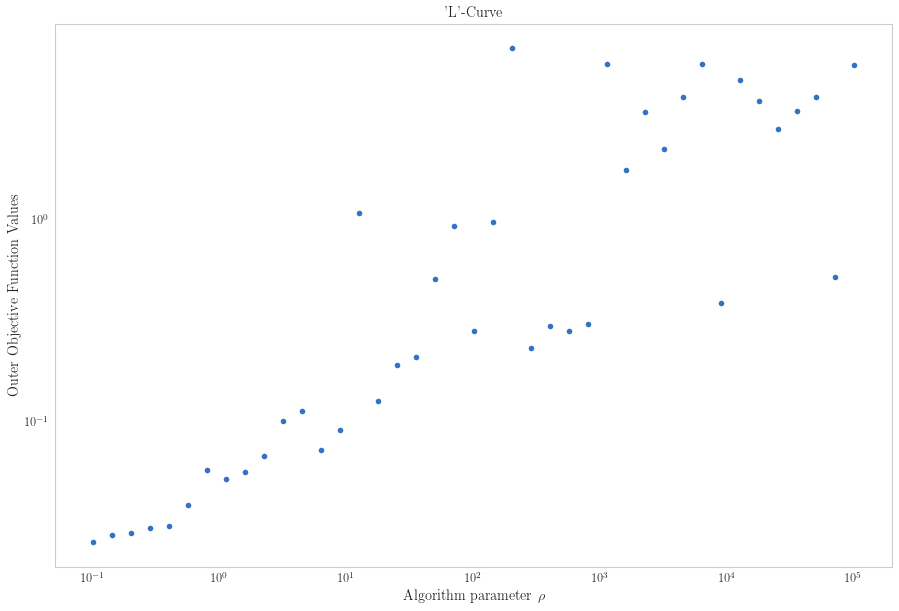

In [142]:
plt.loglog(*outer_list.T, 'o')
plt.xlabel(r"Algorithm parameter $\rho$ ")
plt.ylabel(r"Outer Objective Function Values")
plt.title("'L'-Curve")

In [33]:
def gen_key(sol_key, solution):
    return "y".join(map(str,solution.x)) + "r" + sol_key

In [34]:
inner_evals = dict()
for soli in solver.solutions:
    key = gen_key(soli, solver.solutions[soli][0])
    inner_evals[soli] = solver.problems[0].cache.results[key]
    

Text(0.5, 0, '$\\rho$, Algorithm Parameter')

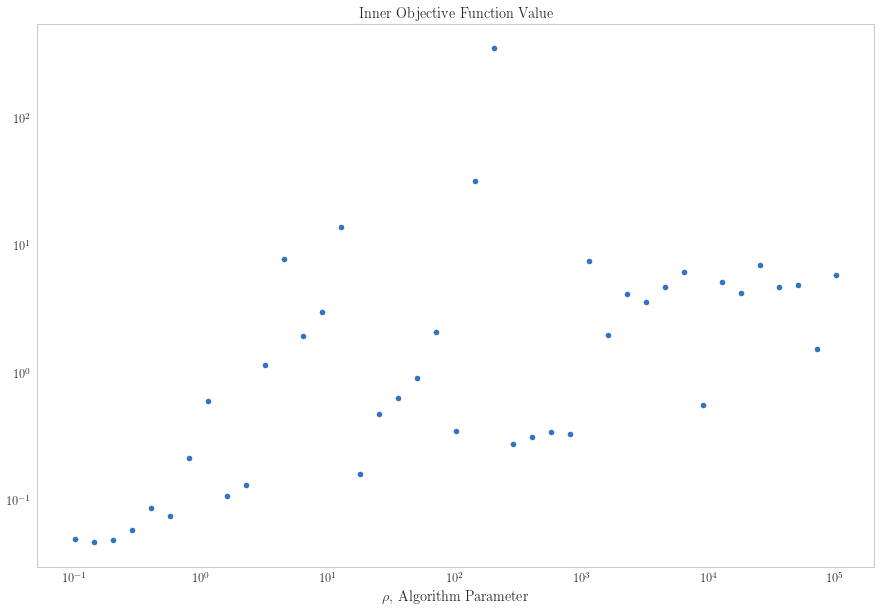

In [143]:
new_list = []
for key in inner_evals.keys():
    new_list.append((float(key), inner_evals[key].fun))
new_list = np.array(new_list)
plt.loglog(*np.array(new_list).T, 'o')
plt.title("Inner Objective Function Value")
plt.xlabel(r"$\rho$, Algorithm Parameter")

In [36]:
diff_field_value = [[okey, (ivalue-ovalue)/(ikey)] 
                    for (ikey, ivalue), (okey, ovalue) in zip(new_list, outer_list)]

Text(0.5, 0, '$\\rho$, Algorithm Parameter')

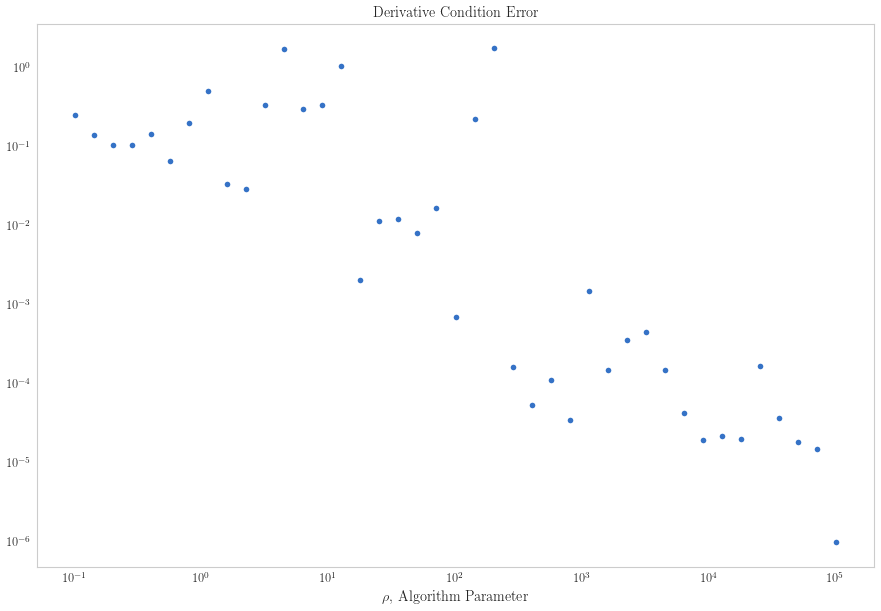

In [144]:
plt.loglog(*np.array(diff_field_value).T, 'o')
plt.title("Derivative Condition Error")
plt.xlabel(r"$\rho$, Algorithm Parameter")

Text(0, 0.5, 'Number')

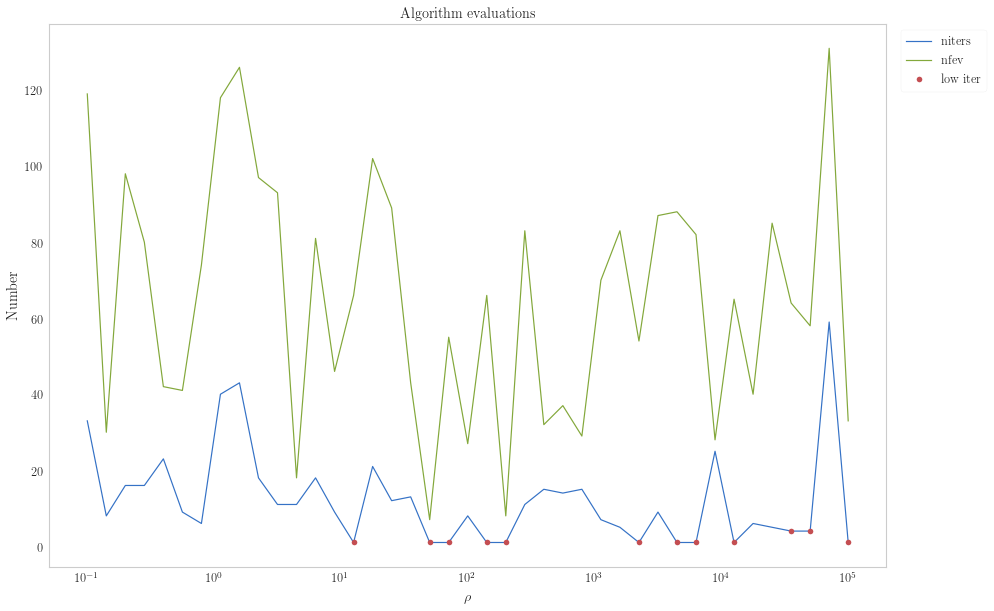

In [145]:
iters_list = np.array([[float(key), value[0].nit] for key, value in solver.solutions.items()])
fevs_list = np.array([[float(key), value[0].nfev] for key, value in solver.solutions.items()])
plt.semilogx(*iters_list.T, *fevs_list.T)

low_iters = np.array([[k,v] for k,v in iters_list if v < 5])
plt.plot(*low_iters.T, 'ro')

plt.legend(["niters", "nfev", "low iter"], 
           loc="best", bbox_to_anchor=(1.01, 1))
plt.title("Algorithm evaluations")
plt.xlabel(r"$\rho$")
plt.ylabel("Number")

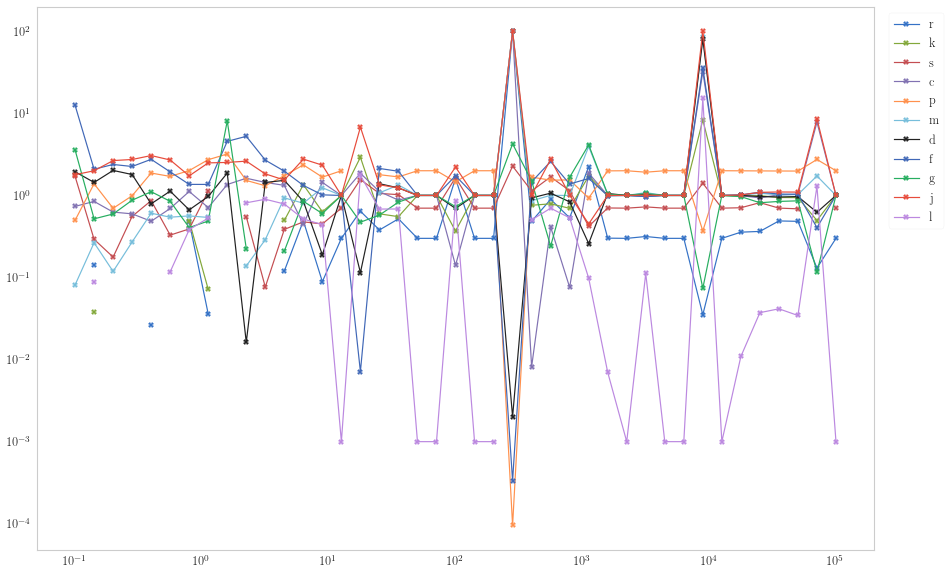

In [146]:
rhos = [float(rho) for rho in solver.solutions.keys()]
vals = [val[0].x for val in solver.solutions.values()]
plt.plot(rhos, vals, 'X-')
plt.legend("rkscpmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

In [114]:
results = pd.DataFrame({r"$\rho$": np.log(rhos)})
for idx, name in enumerate("rkpcsmdfgjl"):
    results[name] = [v[idx] for v in vals]

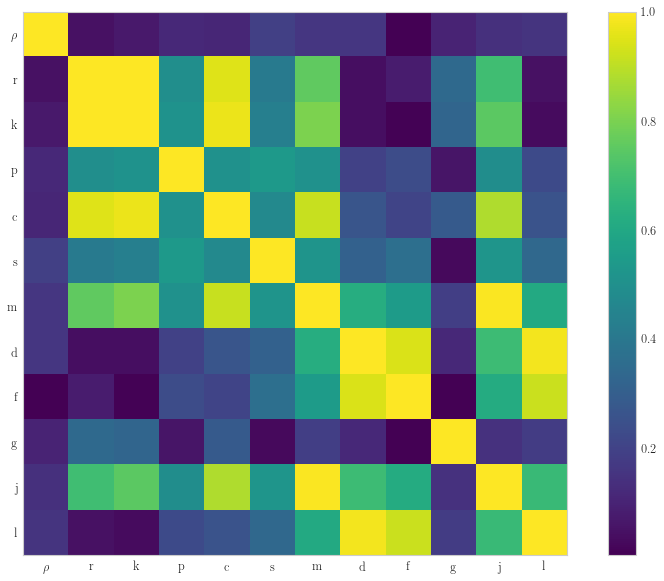

In [147]:
plt.imshow(np.abs(results.corr()))
plt.colorbar()
plt.xticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.yticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.grid(False)

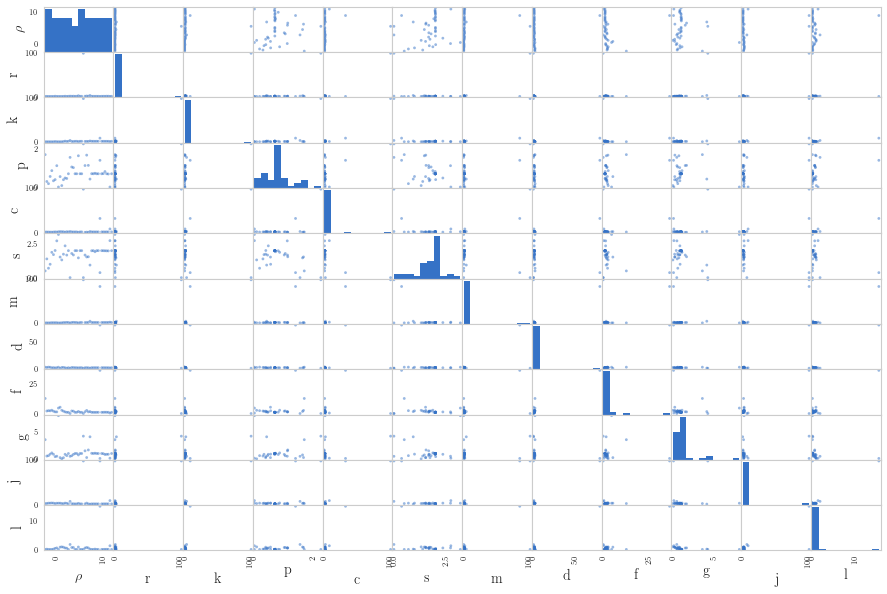

In [148]:
ax = pd.plotting.scatter_matrix(results)
for a in ax.flatten():
    a.grid(False)